Dataset 'hackaton1' already exists. Deleting...
Importing dataset from images in D:\Genta\ML_practice\voxel\Visual-ai\images and annotations in D:\Genta\ML_practice\voxel\Visual-ai\annotations
 100% |█████████████████| 665/665 [1.5s elapsed, 0s remaining, 435.0 samples/s]         
Imported 665 samples
Dataset stats: {'samples_count': 665, 'samples_bytes': 619242, 'samples_size': '604.7KB', 'total_bytes': 619242, 'total_size': '604.7KB'}

Sample file paths:
 - D:\Genta\ML_practice\voxel\Visual-ai\images\potholes313.png
 - D:\Genta\ML_practice\voxel\Visual-ai\images\potholes545.png
 - D:\Genta\ML_practice\voxel\Visual-ai\images\potholes572.png



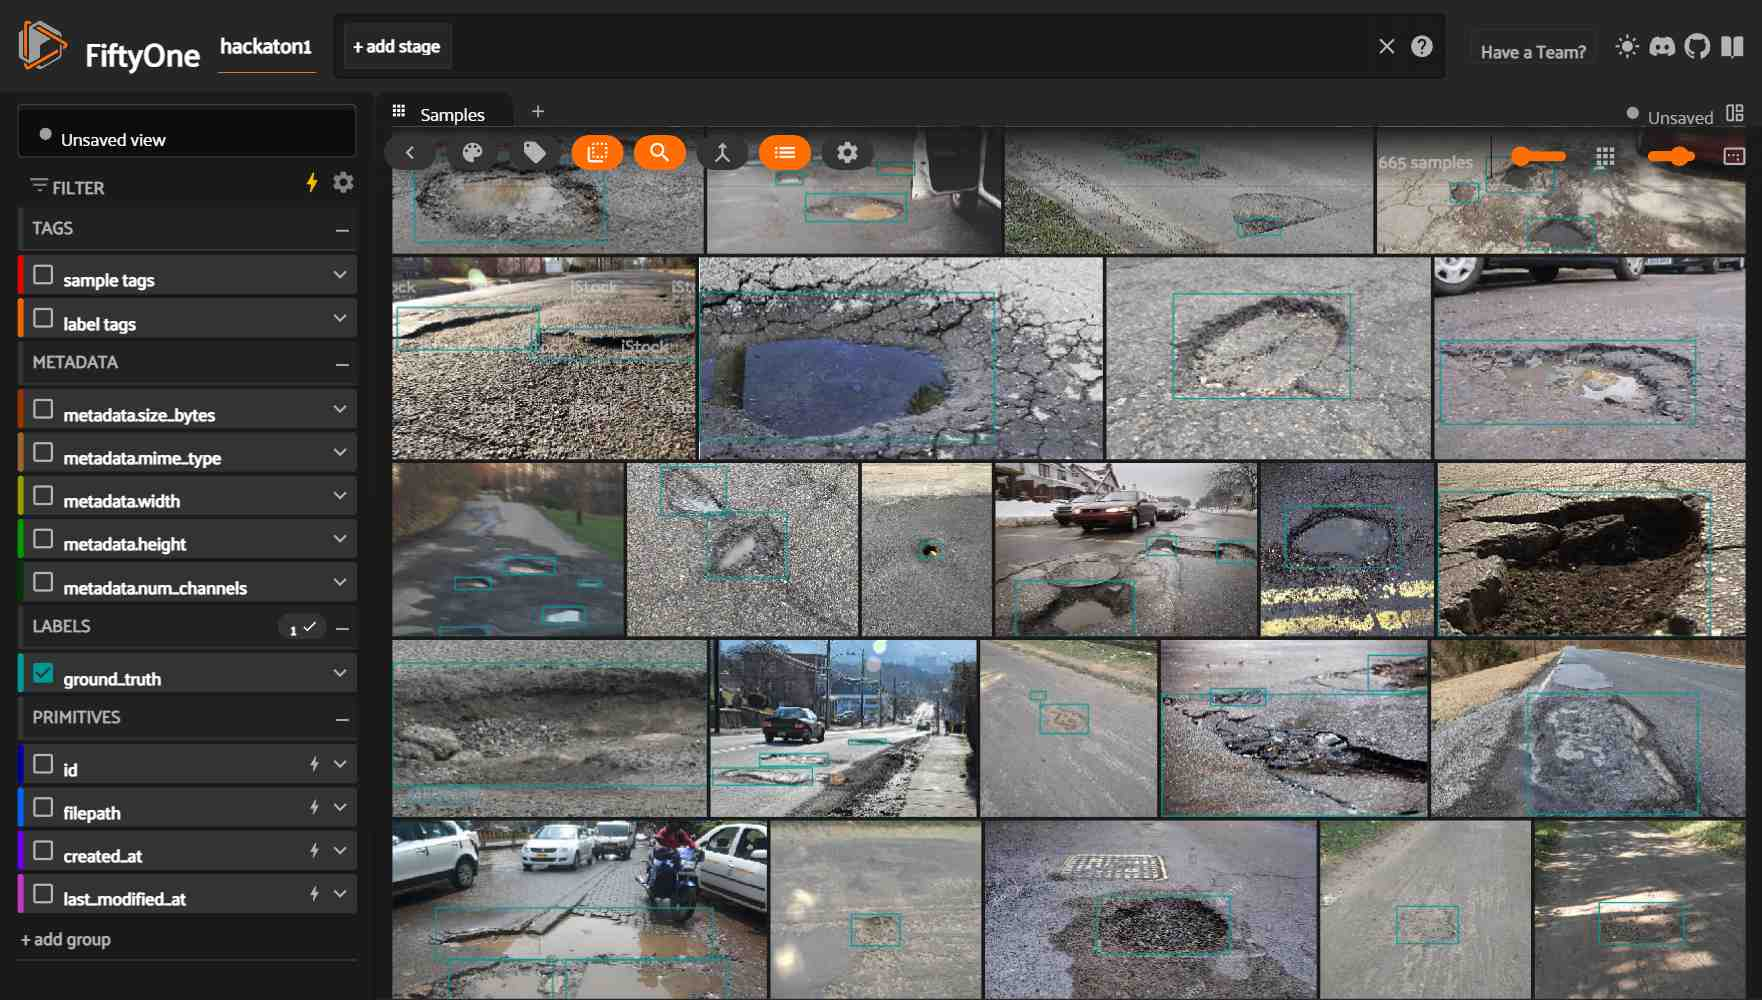

In [15]:
import fiftyone as fo
import os
from pathlib import Path

# Define paths
name = "hackaton1"
data_path = r"D:\Genta\ML_practice\voxel\Visual-ai\images"
labels_path = r"D:\Genta\ML_practice\voxel\Visual-ai\annotations"

# Check if the dataset already exists and delete it if necessary
if fo.dataset_exists(name):
    print(f"Dataset '{name}' already exists. Deleting...")
    fo.delete_dataset(name)

# Verify directories exist
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Images directory not found: {data_path}")

if not os.path.exists(labels_path):
    raise FileNotFoundError(f"Annotations directory not found: {labels_path}")

print(f"Importing dataset from images in {data_path} and annotations in {labels_path}")

# Import dataset by explicitly providing paths to the source media and labels
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.VOCDetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name=name,
)

# Print dataset summary
print(f"Imported {len(dataset)} samples")
print(f"Dataset stats: {dataset.stats()}")

# View sample paths to ensure they're correct
print("\nSample file paths:")
for sample in list(dataset.take(3)):
    print(f" - {sample.filepath}")
    if hasattr(sample, "detections") and sample.detections is not None:
        print(f"   Has {len(sample.detections.detections)} detections")

# Set some default options for visualization
dataset.persistent = True
if dataset.has_field("detections"):
    dataset.default_skeleton = "detections"
    # Set a nice color for pothole detections
    dataset.default_classes = ["pothole"]
    dataset.default_detection_colors = {
        "pothole": (255, 0, 0)  # Red color
    }
dataset.save()

# Launch the app
session = fo.launch_app(dataset)

In [32]:
from ultralytics import YOLO

detection_model = YOLO("yolov8n.pt")
seg_model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 7.42MB/s]


100%|██████████| 6.74M/6.74M [00:00<00:00, 9.45MB/s]


In [34]:
from ultralytics import YOLO

# Load the smaller YOLOv8 model (YOLOv8n)
model = YOLO("yolov8n.pt")  # Use the 'yolov8n.pt' model (smallest version)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Loop through the dataset and run inference
for sample in dataset:
    # Perform inference on the image file
    results = model(sample.filepath)  # Run inference

    detections = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates
            label = model.names[int(box.cls[0])]  # Class label
            conf = float(box.conf[0])  # Confidence score

            # Convert to relative coordinates (required by FiftyOne)
            width, height = sample.metadata.width, sample.metadata.height
            rel_x = x1 / width
            rel_y = y1 / height
            rel_w = (x2 - x1) / width
            rel_h = (y2 - y1) / height

            # Create FiftyOne Detection object
            detections.append(
                fo.Detection(
                    label=label,
                    bounding_box=[rel_x, rel_y, rel_w, rel_h],
                    confidence=conf,
                )
            )

    # Add the detections to the sample's annotations
    sample["yolo_predictions"] = fo.Detections(detections=detections)
    sample.save()

print("Inference complete! Detections saved in Voxel51.")



image 1/1 D:\Genta\ML_practice\voxel\Visual-ai\images\potholes0.png: 448x640 9 cars, 98.6ms
Speed: 3.1ms preprocess, 98.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 D:\Genta\ML_practice\voxel\Visual-ai\images\potholes1.png: 480x640 1 car, 2 trucks, 110.3ms
Speed: 2.4ms preprocess, 110.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 D:\Genta\ML_practice\voxel\Visual-ai\images\potholes10.png: 640x640 (no detections), 22.6ms
Speed: 5.8ms preprocess, 22.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\Genta\ML_practice\voxel\Visual-ai\images\potholes100.png: 480x640 (no detections), 88.1ms
Speed: 1.8ms preprocess, 88.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 D:\Genta\ML_practice\voxel\Visual-ai\images\potholes101.png: 384x640 1 car, 87.4ms
Speed: 1.6ms preprocess, 87.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 D:\Gen

In [ ]:
# Launch FiftyOne app to visualize results
session = fo.launch_app(dataset)
